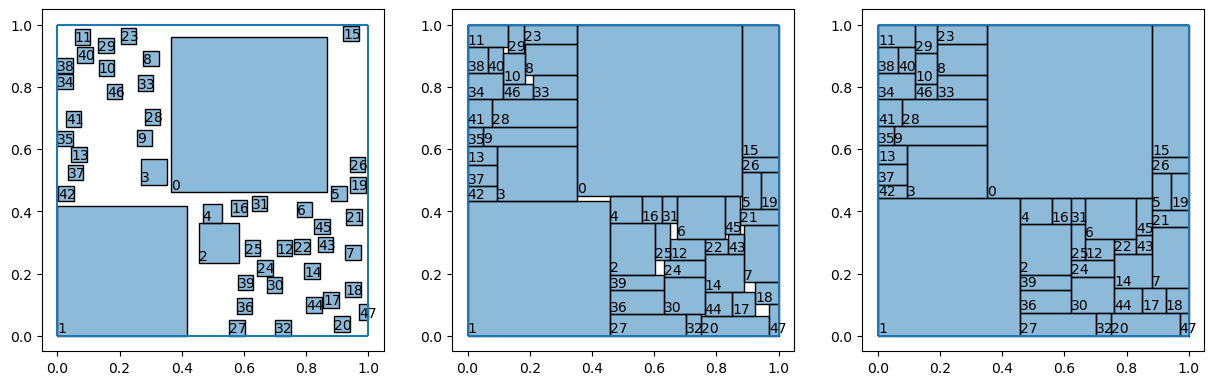

In [1]:
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation(config={'seed' : 123456})# 1000000000000001})#123456})
rects.execute(num=200)
rects.prepare_constraints(keep_feasible=False)
rects.close_holes()

rects.draw(disjoint=True, inflated=True, closed=True)

In [19]:
import numpy as np
# print(rects.sol)
# rects.report(closed_Q=True, digits=4)
len(rects.linear____constr[5].A)

22

In [2]:
rects.graph_processing(rects.closed)

In [6]:
np.linalg.norm(rects.clinched_rectangles - rects.closed)**2

1.3723746186146555

#### Maybe x0 from the graph ?

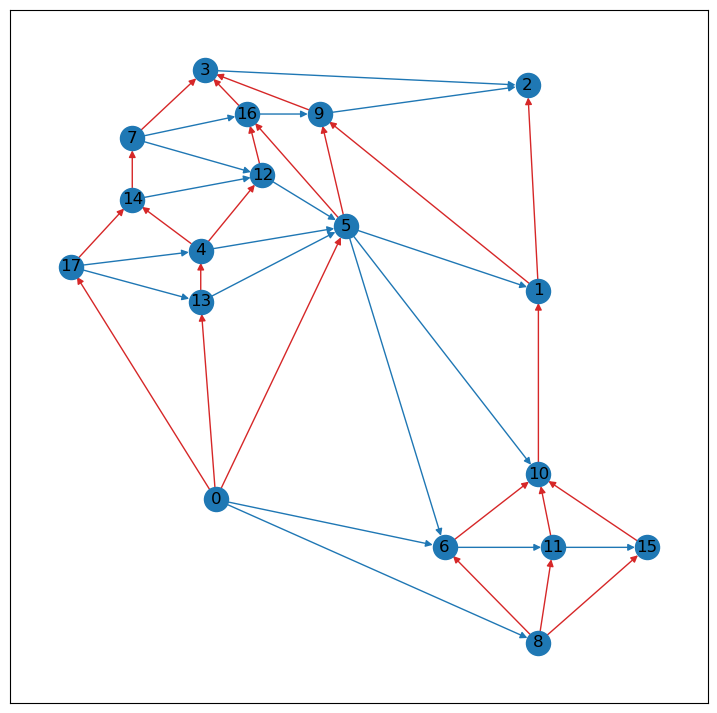

In [3]:
rects.graph_processing(rects.closed)
import networkx as nx
import matplotlib.pyplot as plt
H = nx.from_numpy_array(rects.east_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
V = nx.from_numpy_array(rects.north_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
attrs = { i : {'pos': tuple(row[:2] + 0.5 * row[2:4])} for i, row in enumerate(rects.clinched_rectangles)}
nx.set_node_attributes(H, attrs)
pos = nx.get_node_attributes(H,'pos')
fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(H, pos=pos, ax=ax,  edge_color='tab:blue' )
nx.draw_networkx_edges(V, pos=pos, ax=ax, edge_color='tab:red')
plt.show()

In [73]:
import numpy as np
a = np.arange(80)
a = a.reshape(-1,4)
a[[5,3,7,0]] = np.arange(16).reshape(-1,4)
a

array([[12, 13, 14, 15],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [16, 17, 18, 19],
       [ 0,  1,  2,  3],
       [24, 25, 26, 27],
       [ 8,  9, 10, 11],
       [32, 33, 34, 35],
       [36, 37, 38, 39],
       [40, 41, 42, 43],
       [44, 45, 46, 47],
       [48, 49, 50, 51],
       [52, 53, 54, 55],
       [56, 57, 58, 59],
       [60, 61, 62, 63],
       [64, 65, 66, 67],
       [68, 69, 70, 71],
       [72, 73, 74, 75],
       [76, 77, 78, 79]])

#### (w,h) Distribution playground

In [3]:
import numpy as np
pts_diag = np.array(
                 [[0.25, 0.25],
                  [0.75, 0.75]])
def tepui(
        base:float=0.05,
        top:float=0.3,
        slope:float=4,
        vertex:float=1,
        pts:np.ndarray=pts_diag
):
    return lambda pt : np.minimum(top, np.maximum(base, vertex - slope * np.min(np.linalg.norm(pts - pt, axis=1))))

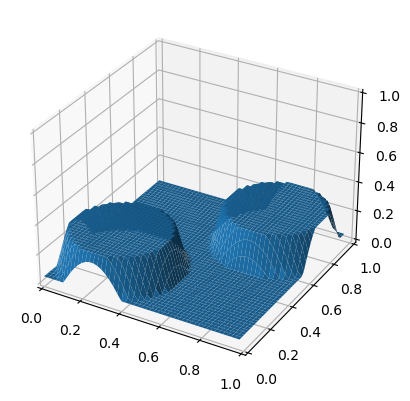

In [6]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

tepui_at = tepui(
        base=0.05,
        top=0.3,
        slope=5,
        vertex=1.5,
)

x = np.arange(0, 1, 0.02)
y = np.arange(0, 1, 0.02)

X, Y = np.meshgrid(x, y)
points = np.array([X,Y])

nu = np.apply_along_axis(tepui_at, 0, points)

fig = plt.figure()
ax:Axes = fig.add_subplot(projection='3d')
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
ax.plot_surface(X, Y, nu)
plt.show()

In [17]:
import numpy as np
x = np.arange(16).reshape(-1,4)
y = np.ones(shape=(4,4))
np.linalg.norm(x-y )


31.874754901018456

In [2]:
import numpy as np
np.where(np.sum(rects.east_neighbours, axis=1) == 0)[0]
# for rect_num in range(shape[0]):
#         if np.sum(upper_neighbours.T[rect_num]) == 0:

array([ 1,  2,  8, 10, 15], dtype=int64)

In [11]:
np.ravel_multi_index(([2, 3], 0), (7,4))

array([ 8, 12], dtype=int64)